# IXO Modelling

**Objective**

Determine if there is a feasible mechanism to tie the reserve of the market maker mechanism with the reserve of the brokerage mechanism, to maintain the peg stability during the period needed to bootstrap the system. Acknowledging the discussed assumptions, incentive mechanisms, and actors, in the system - the ultimate objective is to ensure actors are incentivized to supply their assets into the system in exchange for utility so that the system can be bootstrapped effectively.

**Sprint 1 Scope**

1. Customize and parameterize the existing augmented bonding curve model developed by BlockScience
2. Determine the most suitable mechanism for tying the two reserves together (using the Kyber network and Uniswap mechanisms as inspiration)
3. Determine what parameters we have available to stabilize the market maker peg (initial assumption - use the reserve ratio, and possible exit taxation to prime this mechanism)
4. Determine if the mechanism is theoretically feasible

**Resources**

1. Augmented bonding curve hatch_sim notebook:  [https://github.com/BlockScience/conviction/blob/master/hatch_sim.ipynb](https://github.com/BlockScience/conviction/blob/master/hatch_sim.ipynb)
2. Kyber network reserve types: [https://developer.kyber.network/docs/Reserves-Types/](https://developer.kyber.network/docs/Reserves-Types/)

## IXO Liquidity Mechanism

### Uniswap Notes

Uniswap mechanism for liquidity provider / delegators brokerage:
* Uniswap liquidity pools are autonomous and use the Constant Product Market Maker (x * y = k)
* A small liquidity provider fee (0.3%) is taken out of each trade and added to the reserves
* Formal verification: https://github.com/runtimeverification/verified-smart-contracts/blob/uniswap/uniswap/x-y-k.pdf
* The invariant is that the ratio of e:t:l is preserved and k = e * t increases (e is ether, t is exchange tokens, and l is total liquidity / supply of uni tokens)
* By supplying and burning liquidity (uni tokens), the investor can exchange for their share of ether and tokens

Uni-token === IXO staking token
If you stake you're delegating, and delegators receive a proportion of the networks fees, block rewards/inflation, service fees from oracles

### Dependancies

In [75]:
import sys
sys.path.append("../../venv/lib/python3.7/site-packages" )

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

from bonding_curve_eq import *

### Helper Functions

In [76]:
def get_node_ids_of_type(network, _type):
    return [x for x,y in network.nodes(data=True) if y['_type']==_type]

### Liquidity Mechanisms Overview

In [77]:
# Automated Market Maker: Issues IXO tokens in exchange for DAI

# Brokerage Initial State: Issues IXOS / staking tokens to delegators

# Delegators: The liquidity providers
liquidity_provider_fee = .03 # percent

# IBC Ethereum Peg-Zone:
# 1. IXO from AMM and DAI staked into reserve pool by delegators in exchange for IXOS
# 2. cIXO and cIXOS matched on IXO-Cosmos network
# 3. This mechanism can be spun down, while maintaining the liquidity created, when the IBC mechanism is operational

### Initial State

In [87]:
validators_min = 10
validators_max = 20

initial_ixo_supply = 2e9
founders_stake = .1 # percent
initial_ixos_supply = initial_ixo_supply * founders_stake # initial supply of staking vouchers

initial_ixo_price = .1 # average IXO price from ixo.world Euro cents
initial_ixos_price = .2 # staking voucher price from AMM in Euro cents

ixo_delegation_distribution_value = 1e6
ixo_delegation_distribution_supply = 1e6/initial_ixo_price #200e6 # 5 strategic delegations worth Euro 1 Mil each

# Augmented bonding curve parameters
# Hatch state
d0 = 1 # million DAI
p0 = .10 # DAI per tokens
theta = 0 #.35 # Funding pool taxation - 0 implies all contributions allocated to market

R0 =  d0*(1-theta) # million DAI
S0 = d0/p0

kappa = 1 # Bonding curve curvature - using an initial kappa value of 1 we can keep a constant token price for initial bootstrap phase
tax = .02 # exit tax - introduces friction and possibly funds to prime stability mechanisms

## Augumented bonding curve Mathematics

### Hatch Sale Equations

- Initial Raise $d_0$ Dai
- Initial Reserve is $R_0 = (1-\theta) d_0$
- Hatch sale Price $p_0$ (dai per token) determines the initial supply: $S_0 = d_0/p_0$
- Power Function Invariant shape: $V(R, S) = \frac{S^\kappa}{R}$
- Price function (DAI per Token): $P(R) = \frac{\kappa R^{(\kappa-1)/ \kappa}}{V_0^{1 / \kappa}}$
- Supply function (tokens): $S(R) = \sqrt[\kappa]{V_0 R}$
- Reserve function (xDAI): $R(S) = \frac{S^{\kappa}}{V_0} $
- The invariant coef: $V_0 = V(R_0, S_0) = \frac{S_0^\kappa}{R_0} = \left(\frac{1}{p_0(1-\theta)}\right)^\kappa R_0^{\kappa-1}$
- The post hatch price: $p_1=P(R_0) = \frac{\kappa R_0^{(\kappa-1)/ \kappa}}{V_0^{1 / \kappa}} = \kappa R_0^{(\kappa-1)/ \kappa} \cdot(1-\theta)p_0\cdot R_0^{-(\kappa-1)/\kappa} = \kappa(1-\theta) p_0$
- The Return factor: $\frac{p_1}{p_0} = {\kappa}(1-\theta)$

### Invariant Preserving Deposit-to-Mint
 - Deposit $\Delta R$ xdai 
 - Conservation equation: $V(R+ \Delta R, S+\Delta S) = \frac{(S+\Delta S)^\kappa}{R+\Delta R} =V_0$
 - Derived Mint equation: $\Delta S = mint\big(\Delta R ; (R,S)\big)= \sqrt[\kappa]{V_0(R+\Delta R)}-S$
 - Realized Price is: $\bar{P}(\Delta R) =\frac{\Delta R}{\Delta S} = \frac{\Delta R}{\sqrt[\kappa]{V_0(R+\Delta R)}-\sqrt[\kappa]{V_0(R)}} \rightarrow \big(\frac{\partial S(R)}{\partial R} \big)^{-1}$ as $\Delta R \rightarrow 0$
 - The limiting price is the spot price: $\lim_{\Delta R \rightarrow 0} \bar{P}(\Delta R)=\big(\frac{\partial S(R)}{\partial R}\big)^{-1}= \big(\frac{V_0^{1/\kappa} \cdot  R^{1/\kappa-1}}{\kappa}\big)^{-1}= \frac{\kappa R^{1-1/\kappa}}{V_0^{1/\kappa}} = \frac{\kappa R^{(\kappa-1)/\kappa}}{V_0^{1/\kappa}} =P(R)$
 
### Invariant Preserving Burn-to-Withdraw
 - Burn $\Delta S$ tokens
 - Conservation equation: $V(R- \Delta R, S-\Delta S) = \frac{(S-\Delta S)^\kappa}{R-\Delta R} =V_0$
 - Derived Withdraw equation: $\Delta R = withdraw\big(\Delta S ; (R,S)\big)= R-\frac{(S-\Delta S)^\kappa}{V_0}$
 - Realized Price is: $\bar{P}(\Delta S) =\frac{\Delta R}{\Delta S} = \frac{\frac{S^{\kappa}}{V_0}-\frac{(S-\Delta S)^\kappa}{V_0}}{\Delta S} \rightarrow \frac{\partial R(S)}{\partial S} $ as $\Delta S \rightarrow 0$
 - The limiting price is the spot price: $\lim_{\Delta S \rightarrow 0} \bar{P}(\Delta S)=\frac{\partial R(S)}{\partial S}=\frac{\kappa S^{\kappa-1}}{V_0} = \frac{\kappa \cdot (\sqrt[\kappa]{V_0 R})^{\kappa-1}}{V_0}= \frac{\kappa R^{(\kappa-1)/\kappa}}{V_0^{1/\kappa}}=P(R)$
 - Given friction coef $\phi$ 
     - sent to burning agent address: $\Delta R_{agent} = (1-\phi) \Delta R$
     - sent to the funding pool address: $\Delta R_{pool} = \phi \Delta R$
     - due to the friction the true realized price for the agent is $(1-\phi)\cdot \bar{P}(\Delta S)$
     - due to the friction the true return factor post withdraw is: ${\kappa}(1-\theta)(1-\phi)$

## Bonding curve parameter analysis

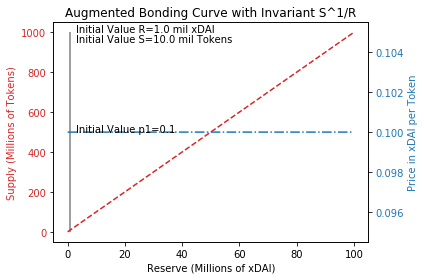

In [88]:
V0 = invariant(R0,S0,kappa)

reserve = np.arange(0,100,.01)
supp = np.array([supply(r, V0, kappa) for r in reserve])
price = np.array([spot_price(r, V0, kappa) for r in reserve])

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Reserve (Millions of xDAI)')
ax1.set_ylabel('Supply (Millions of Tokens)', color=color)
ax1.plot(reserve, supp,'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
ax2.plot(reserve, price,'-.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.vlines(R0,0,supp[-1], alpha=.5)
ax1.text(R0+.02*reserve[-1], supp[-1], "Initial Value R="+str(int(100*R0)/100)+" mil xDAI")
ax1.text(R0+.02*reserve[-1], .95*supp[-1], "Initial Value S="+str(S0)+" mil Tokens")
#ax1.hlines(S0,0,R0)

ax2.text(R0+.02*reserve[-1], price[3], "Initial Value p1="+str(int(100*spot_price(R0,V0,kappa))/100))


plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

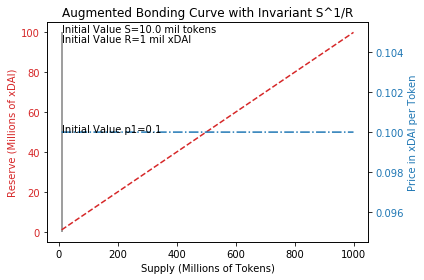

In [89]:
fig, ax1 = plt.subplots()

cp = 100
color = 'tab:red'
ax1.set_xlabel('Supply (Millions of Tokens)')
ax1.set_ylabel('Reserve (Millions of xDAI)', color=color)
ax1.plot(supp[cp:], reserve[cp:],'--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
ax2.plot(supp[cp:], price[cp:],'-.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.vlines(S0,0,reserve[-1], alpha=.5)
ax1.text(S0*1.02, reserve[-1], "Initial Value S="+str(int(100*S0)/100)+" mil tokens")
ax1.text(S0*1.02, .95*reserve[-1], "Initial Value R="+str(R0)+" mil xDAI")
#ax1.hlines(S0,0,R0)

ax2.text(S0*1.02, price[3], "Initial Value p1="+str(int(100*spot_price(R0,V0,kappa))/100))


plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [90]:
#given V0 and kappa
#sweep the reserve
reserve = None
reserve = np.arange(.01,100,.01)
price = np.array([spot_price(r,V0,kappa) for r in reserve])

#realized price for withdrawing burning .1% of tokens
withdraw_price=[withdraw(supply(r,V0,kappa)/1000, r,supply(r,V0,kappa), V0, kappa)[1] for r in reserve]

#realized price for depositing .1% more Xdai into the reserve
mint_price=[mint(r/1000, r, supply(r,V0,kappa), V0, kappa)[1] for r in reserve]

In [92]:
pdf = pd.DataFrame({'reserve':reserve, 'spot_price':price, '.1% mint_price':mint_price,'.1% withdraw_price':withdraw_price })

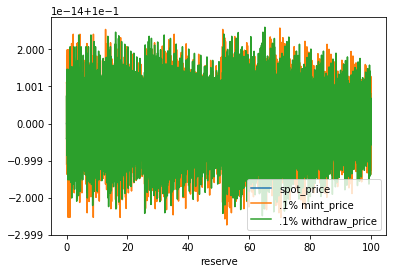

In [93]:
pdf.plot(x='reserve')

In [94]:
pdf['mint_slippage'] = (pdf['.1% mint_price']-pdf['spot_price'])/pdf['spot_price']
pdf['withdraw_slippage'] = (pdf['spot_price']-pdf['.1% withdraw_price'])/pdf['spot_price']

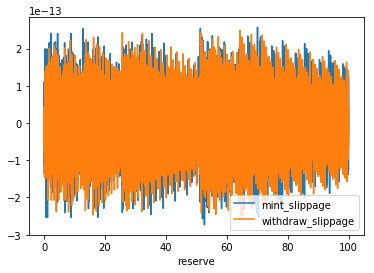

In [95]:
pdf.plot(x='reserve', y = ['mint_slippage', 'withdraw_slippage'])#, logy=True)

In [96]:
#given V0 and kappa
R = 20
S = supply(R,V0,kappa)
p = spot_price(R,V0,kappa)
#sweep the transaction fraction
TXF = np.logspace(-6, 0, num=1000)

#realized price for withdrawing burning .1% of tokens
withdraw_price2=[withdraw(S*txf, R,S, V0, kappa)[1] for txf in TXF]

#realized price for depositing .1% more Xdai into the reserve
mint_price2=[mint(R*txf, R,S, V0, kappa)[1] for txf in TXF]

In [97]:
print(S)

200.0


In [98]:
pdf2 = pd.DataFrame({'tx_fraction':TXF, 'spot_price':p*np.ones(len(TXF)), 'mint_price':mint_price2,'withdraw_price':withdraw_price2 })

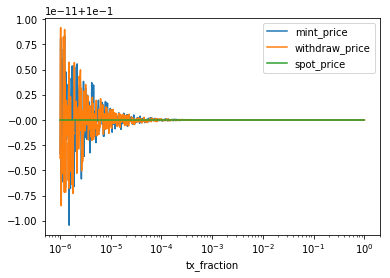

In [99]:
pdf2.plot(x='tx_fraction',y=['mint_price','withdraw_price','spot_price'], logx=True)

In [100]:
pdf2['mint_slippage'] = (pdf2['mint_price']-pdf2['spot_price'])/pdf2['spot_price']
pdf2['withdraw_slippage'] = (pdf2['spot_price']-pdf2['withdraw_price'])/pdf2['spot_price']

Text(0.5, 0, 'Transaction size as percent of the asset Burned or Bonded')

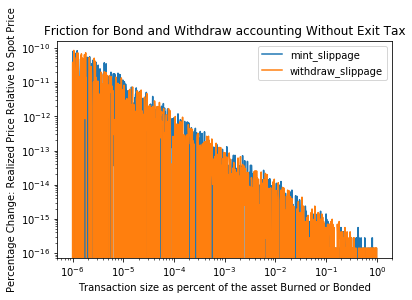

In [101]:
pdf2.plot(x='tx_fraction', y = ['mint_slippage', 'withdraw_slippage'], logx=True, logy=True)
plt.title("Friction for Bond and Withdraw accounting Without Exit Tax")
plt.ylabel("Percentage Change: Realized Price Relative to Spot Price")
plt.xlabel("Transaction size as percent of the asset Burned or Bonded")

In [102]:
pdf2['withdraw_slippage_with_tax'] = pdf2['withdraw_slippage']+tax

Text(0.5, 0, 'Transaction size as percent of the asset Burned or Bonded')

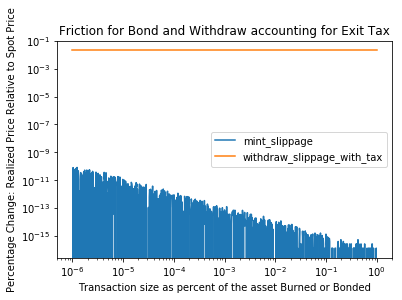

In [103]:
pdf2.plot(x='tx_fraction', y = ['mint_slippage', 'withdraw_slippage_with_tax'], logx=True, logy=True)
plt.title("Friction for Bond and Withdraw accounting for Exit Tax")
plt.ylabel("Percentage Change: Realized Price Relative to Spot Price")
plt.xlabel("Transaction size as percent of the asset Burned or Bonded")

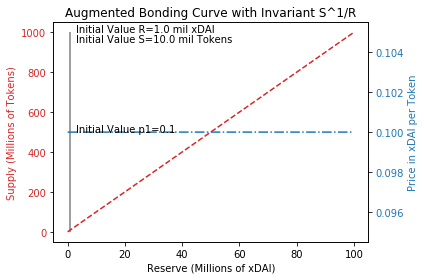

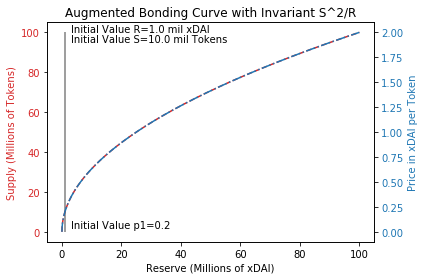

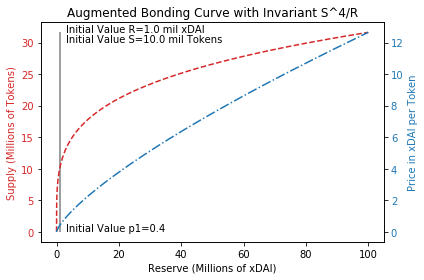

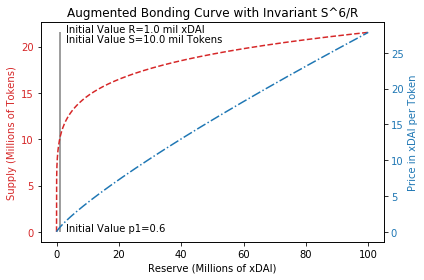

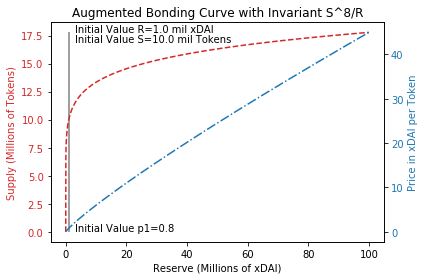

In [104]:
Kappa_List = [1,2,4,6,8]
for kappa in Kappa_List:
    
    V0 = invariant(R0,S0,kappa)
    
    reserve = np.arange(0,100,.01)
    supp = np.array([supply(r, V0, kappa) for r in reserve])
    price = np.array([spot_price(r, V0, kappa) for r in reserve])

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Reserve (Millions of xDAI)')
    ax1.set_ylabel('Supply (Millions of Tokens)', color=color)
    ax1.plot(reserve, supp,'--', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
    ax2.plot(reserve, price,'-.', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.vlines(R0,0,supp[-1], alpha=.5)
    ax1.text(R0+.02*reserve[-1], supp[-1], "Initial Value R="+str(int(100*R0)/100)+" mil xDAI")
    ax1.text(R0+.02*reserve[-1], .95*supp[-1], "Initial Value S="+str(int(100*S0)/100)+" mil Tokens")
    #ax1.hlines(S0,0,R0)

    ax2.text(R0+.02*reserve[-1], price[3], "Initial Value p1="+str(int(1000*spot_price(R0,V0,kappa))/1000))


    plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()